# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

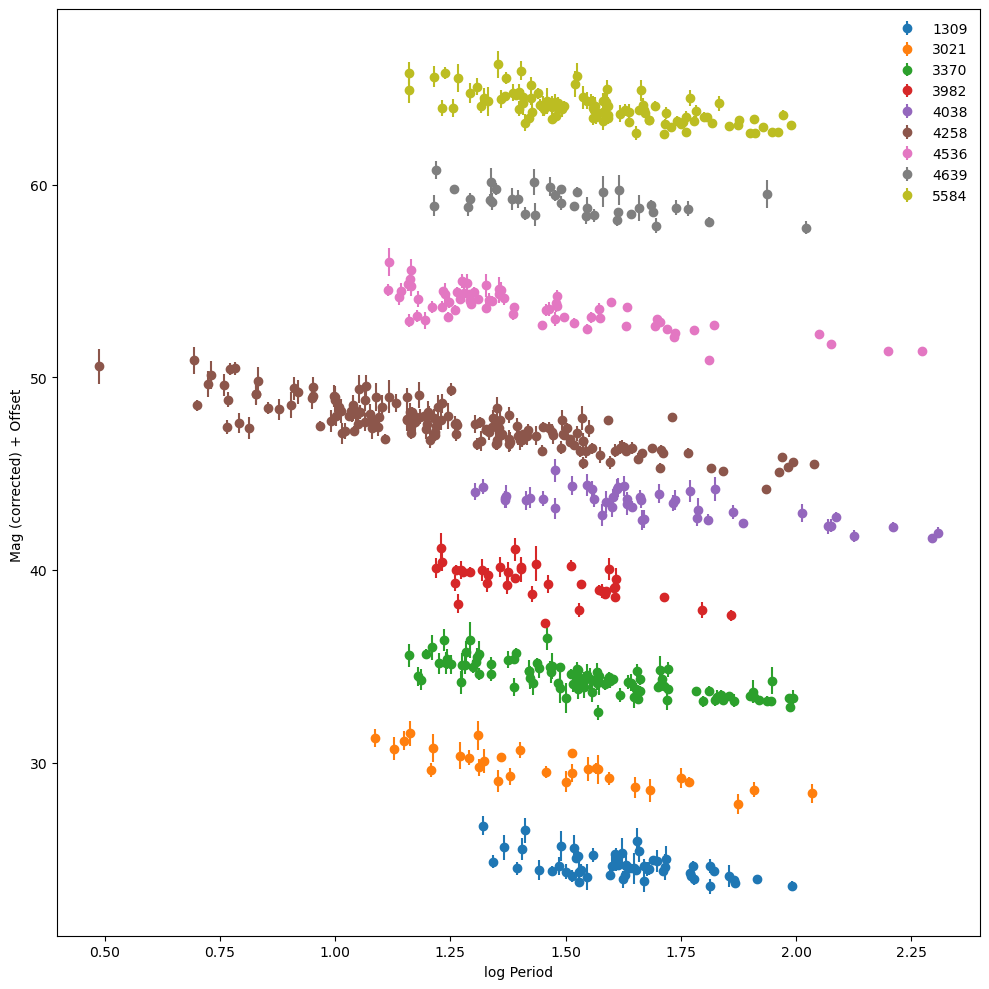

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


The Likelihood is given by:

$$ L = \Pi_{i,j=0} \frac{1}{\sqrt{2 \pi \sigma_{W,i,j}}} \text{exp}(\frac{-(m_{W,i,j}^{\text{obs}} - m_{W,i,j}^{\text{true}})^2}{2(\sigma_{W,i,j}^2 + \sigma_{\text{int}}^2)})$$

Taking the log likelihood:

$$ \log{L} = \log{\Pi_{i,j=0} \frac{1}{\sqrt{2 \pi \sigma_{W,i,j}}}} - \text{exp}(\Sigma_{i,j=0} \frac{(m_{W,i,j}^{\text{obs}} - m_{W,i,j}^{\text{true}})^2}{2(\sigma^2_{W,i,j} + \sigma^2_{\text{int}})})$$

where $ m_{W,i,j}^{\text{true}} = (\mu_i - \mu_{4258}) + zp_{W, 4258} + b_{W}\log{P_{i, j}}$ for the $j^{th}$ is the cepheid in the $i^{th}$ host galaxy.

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

The prior has 10 parameter which we sample over.

For the paramter correspond to the intercept for n4258, I took a gaussian about 0 with a standard deviation of about 3 sigmas as we pass in a best guess for the intercept into the sampler. I kepts the bounds fot this parameter as -5 to 5 to give it some space to samples across.

For 8 other parameters i.e difference in intercepts of the other host galaxies with respect to n4258, I took a uniform function between 0 and 5. I chose the lower limit as 0 as while looking at the data, I found that n4528 had the closes distance and hence the lowest intercept and so physically the difference cannot be lower than 0. The average distance seemed to lie about 2-3 units away while looking at the data and so I picked a upper limit bit higher than this of 5.

Finally for the slope, I picked a gaussian distribution centered on the best fit slope for n4258. Since the slope cannot be ascending, 0 seemed like a good physical upper limit. Once again for the lower limit, I looked at the best fit for n4258 which seemed to be about -3, so I picked a upper limit a bit futher away from this value to allow the sampler to roam around the sample space at about -7.

### Import Statements and Model

In [3]:
import numpy as np
import scipy.optimize as so
import scipy.stats as st
import pandas as pd
import emcee
import corner

In [4]:
def model(mu, zp, bw, logP):
    m = mu + zp + bw*logP
    return m

def chiSquaredLoss(params, mObs, dm, logP, noise):
    mu, zp, bw = params
    dog = len(logP) - len(params)
    
    mTrue = model(mu, zp, bw, logP)
    
    loss = np.sum(((mTrue - mObs)**2/(dm**2 + noise**2)))/dog
    return loss

def HuberLoss(params, mObs, dm, logP):
    mu, zp, bw = params
    
    mTrue = model(mu, zp, bw, logP)
    
    h1 = 0.2*(mTrue - mObs)**2
    h2 = 0.2*(np.abs(mTrue - mObs) - 2.5)
    
    loss = np.where(np.abs(mTrue - mObs) <= 5, h1, h2)
    return np.sum(loss)

### Just messing around with the data

(166,)
(166,)
(166,)


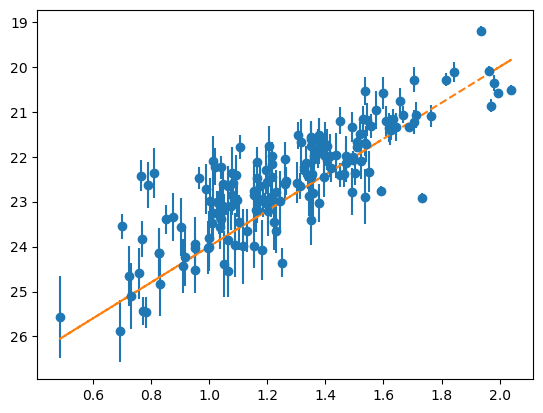

In [5]:
ceph.select("4258")
mobs = ceph.mobs
logP = ceph.logP
sigma_obs = ceph.sigma
plt.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', label="4258")
y = 28 - 4*logP
plt.plot(logP, y, "--")
plt.gca().invert_yaxis()

print(mobs.shape)
print(sigma_obs.shape)
print(logP.shape)

In [6]:
res = so.minimize(HuberLoss, (0, 28, -4), (mobs, sigma_obs, logP))
res

      fun: 14.12490058660471
 hess_inv: array([[ 0.73098742, -0.26901258, -0.35315837],
       [-0.26901258,  0.73098742, -0.35315837],
       [-0.35315837, -0.35315837,  0.54895281]])
      jac: array([4.76837158e-07, 4.76837158e-07, 7.15255737e-07])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([-0.64179235, 27.35820765, -3.28516888])

26.716415304993177
-3.2851688815171864


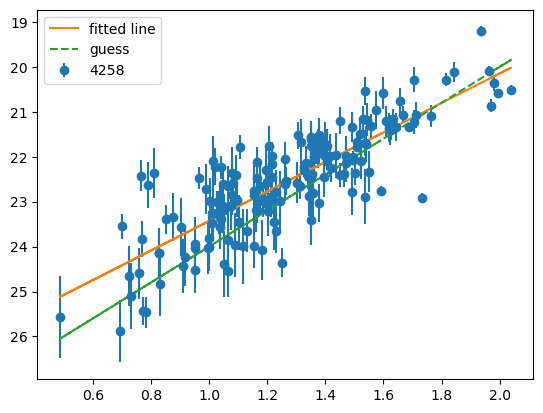

In [7]:
zpval = res.x[0] + res.x[1]
bwval = res.x[2]
plt.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', label="4258")
plt.plot(logP, zpval + bwval*logP, "-", label="fitted line")
plt.plot(logP, 28 - 4*logP, "--", label="guess")
plt.legend()
plt.gca().invert_yaxis()
print(zpval)
print(bwval)

2.022962192856294
2.763198146387854
2.092489699905471
2.454029960422851
0.6571755979463347
0.0
1.2548582323943513
0.20706708574126864


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.7772657404802956
[ 3.9053816   3.08898998  2.62304883  2.26651357  3.24775105  0.
  3.48863937  2.05211669  3.24181009 -3.28516888]


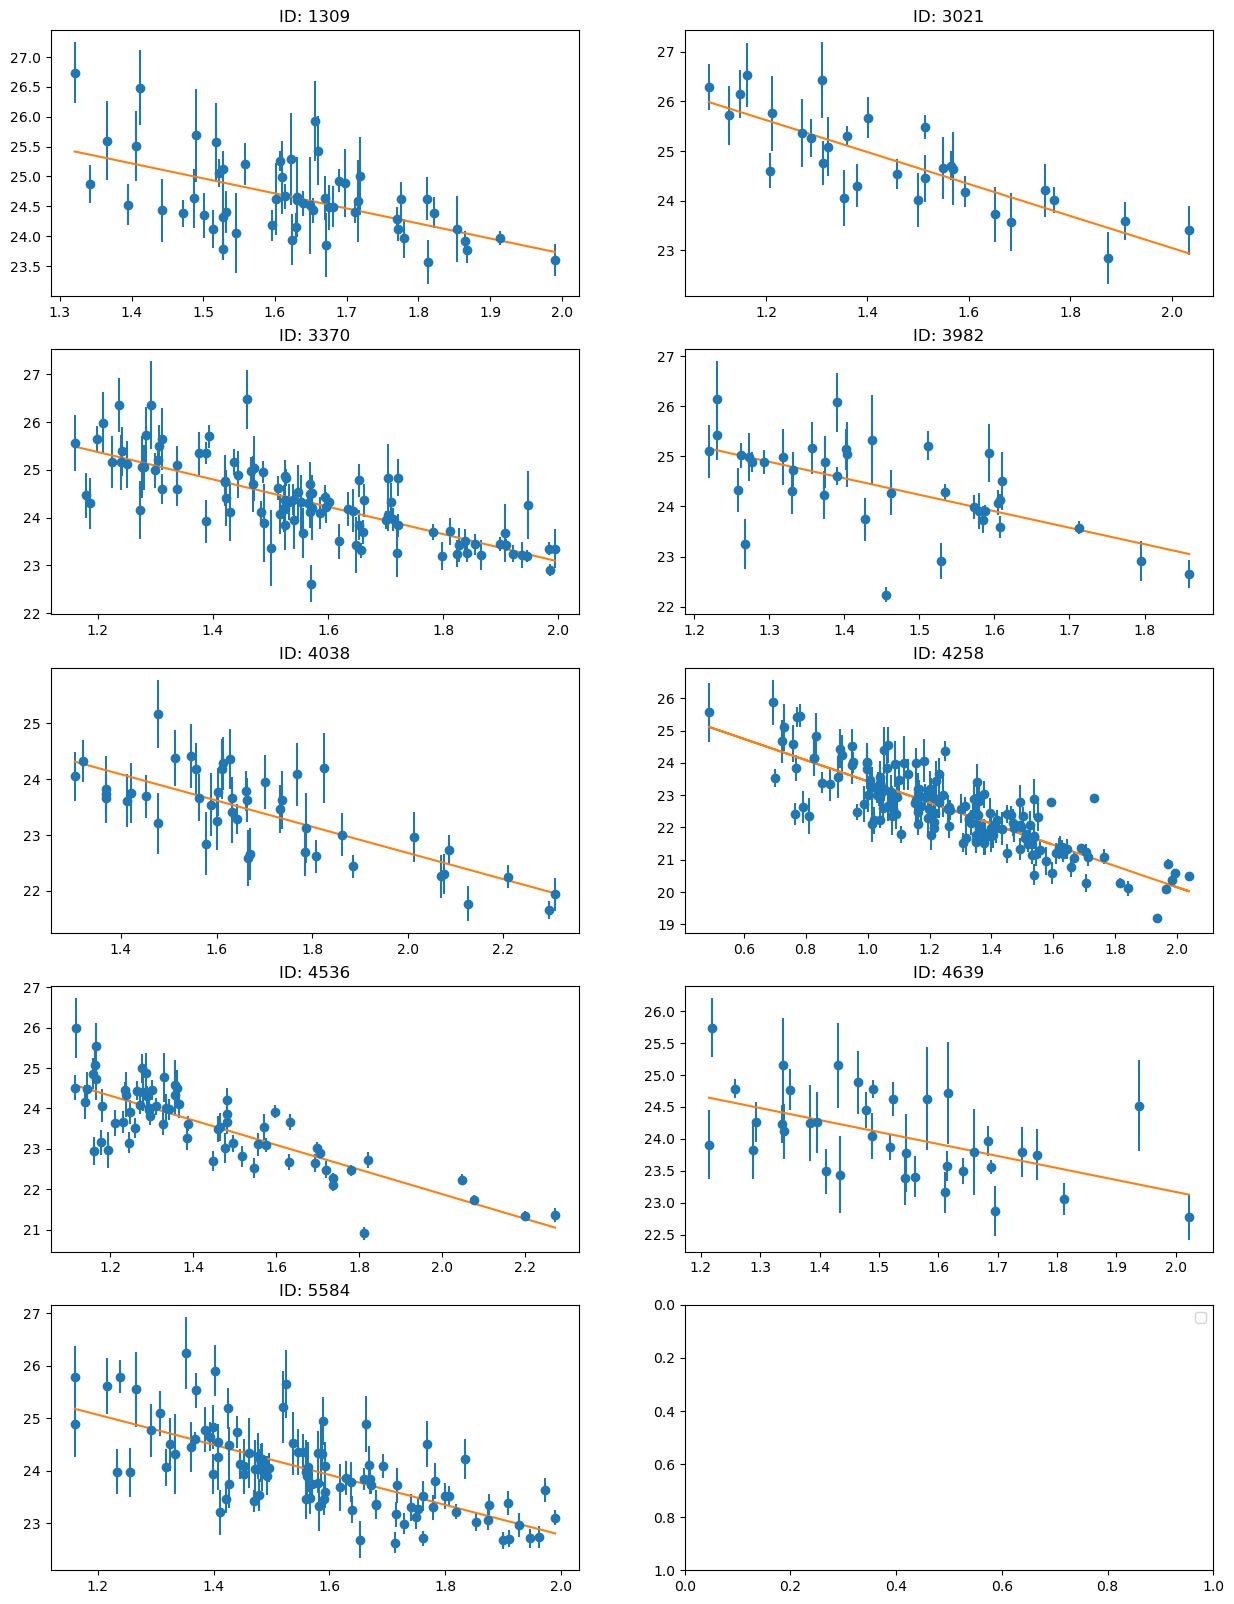

In [8]:
# Just looking at how the intercepts differ with respect to n4258
# Store these values to use as guesses?
distMods = []
muDiff = []
fig, ax = plt.subplots(5, 2, figsize=(15, 20))
for i, ID in enumerate(hosts):
    ceph.select(ID)
    distMods.append(5/2*np.log(ceph.redshifts[ID]/ceph.redshifts["4258"]))
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    j, k = np.unravel_index(i, (5,2))
    ax[j, k].errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    result = so.minimize(HuberLoss, (0, 28, -4), (mobs, sigma_obs, logP))
    ax[j, k].plot(logP, result.x[0] + result.x[1] + result.x[2]*logP)
    print(result.x[0] + result.x[1] - zpval)
    muDiff.append(result.x[0] + result.x[1] - zpval)
    ax[j, k].set_title("ID: " + ID)
distMods.append(bwval)
muDiff.append(bwval)
print((np.array(distMods)))
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [9]:
# Arranging data is a form readable by logLikelihood Function
mObsArray, dmArray, logPArray, noiseArray = [], [], [], []
for i, ID in enumerate(hosts):
    ceph.select(ID)
    mObsArray.append(ceph.mobs)
    logPArray.append(ceph.logP)
    dmArray.append(ceph.sigma)
    noiseArray.append(np.sqrt(np.std(mobs)**2 - np.median(sigma_obs)))

mObsArray, dmArray, logPArray, noiseArray = np.array(mObsArray), np.array(dmArray), np.array(logPArray), np.array(noiseArray)

/var/folders/fk/q2brh0s15vl903bg6tt3wh7h0000gn/T/ipykernel_27328/3708390261.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mObsArray, dmArray, logPArray, noiseArray = np.array(mObsArray), np.array(dmArray), np.array(logPArray), np.array(noiseArray)


# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [10]:
# Defining distributions

def logLikelihood(theta, mObs, dm, logP, noise, zp):
    totalLoss = 0
    for i in range(len(theta)-1):
        if i != 5:
            params = (theta[i], zp, theta[9])
            loss = chiSquaredLoss(params, mObs[i], dm[i], logP[i], noise[i])*(len(logP) - len(params))
            totalLoss += loss
        else:
            params = (0, theta[5] + zp, theta[9])
            loss = chiSquaredLoss(params, mObs[i], dm[i], logP[i], noise[i])*(len(logP) - len(params))
            totalLoss += loss
    return -totalLoss/2 + np.prod(np.log(1/np.sqrt(2*np.pi*dm[i]**2)))
    
    
def logPrior(theta):
    if (theta[0] <= 0 or theta[0] >= 5) or (theta[1] <= 0 or theta[1] >= 5) or (theta[2] <= 0 or theta[2] >= 5) or\
        (theta[3] <= 0 or theta[3] >= 5) or (theta[4] <= 0 or theta[4] >= 5) or (theta[6] <= 0 or theta[6] >= 5) or\
        (theta[7] <= 0 or theta[7] >= 5) or (theta[8] <= 0 or theta[8] >= 5) or (theta[5] <= -3 or theta[5] >= 3) or\
        (theta[9] >= 0 or theta[9] <= -7):
        return -np.inf
    
    pzp = st.norm.pdf(theta[5], loc=0, scale=3)
    pbw = st.norm.pdf(theta[9], loc=-3.2851688, scale=1)
    
    return np.log(np.abs(pzp*pbw))

def logPosterior(theta, mObs, dm, logP, noise, zp):
    logpr = logPrior(theta)
    loglk = logLikelihood(theta, mObs, dm, logP, noise, zp)
    
    return logpr + loglk

In [11]:
# Running emcee
nwalkers = 20
ndim = 10

#guess = np.array(distMods) + np.random.randn(nwalkers, ndim)
guess = np.array(muDiff) + np.random.randn(nwalkers, ndim)

#MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=[mObsArray, dmArray, logPArray, noiseArray, zpval])
state = sampler.run_mcmc(guess, 2500)
sampler.reset()

#print(state)

_ = sampler.run_mcmc(state, 5000)

/Users/athish/opt/anaconda3/envs/fds/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [12]:
samples = sampler.get_chain(flat=True)
samples.shape

(100000, 10)

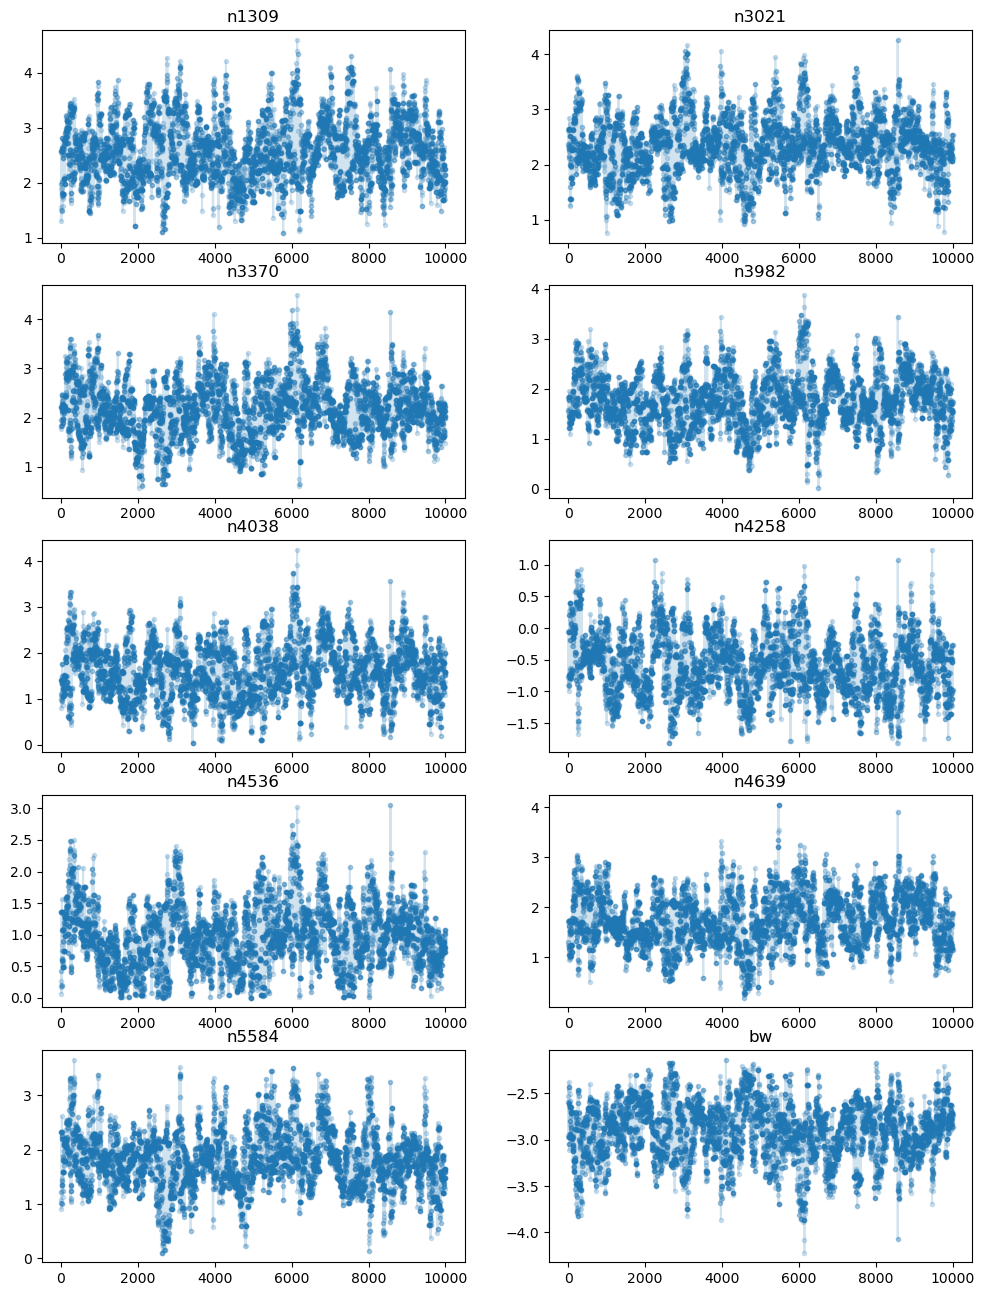

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 16))
labels = ["n1309", "n3021", "n3370", "n3982", "n4038", "n4258", "n4536", "n4639", "n5584", "bw"]

for i in range(5):
    for j in range(2):
        ax[i, j].plot(samples[::10, 2*i + j], marker=".", linestyle="-", alpha=0.2)
        ax[i, j].set_title(labels[2*i + j])

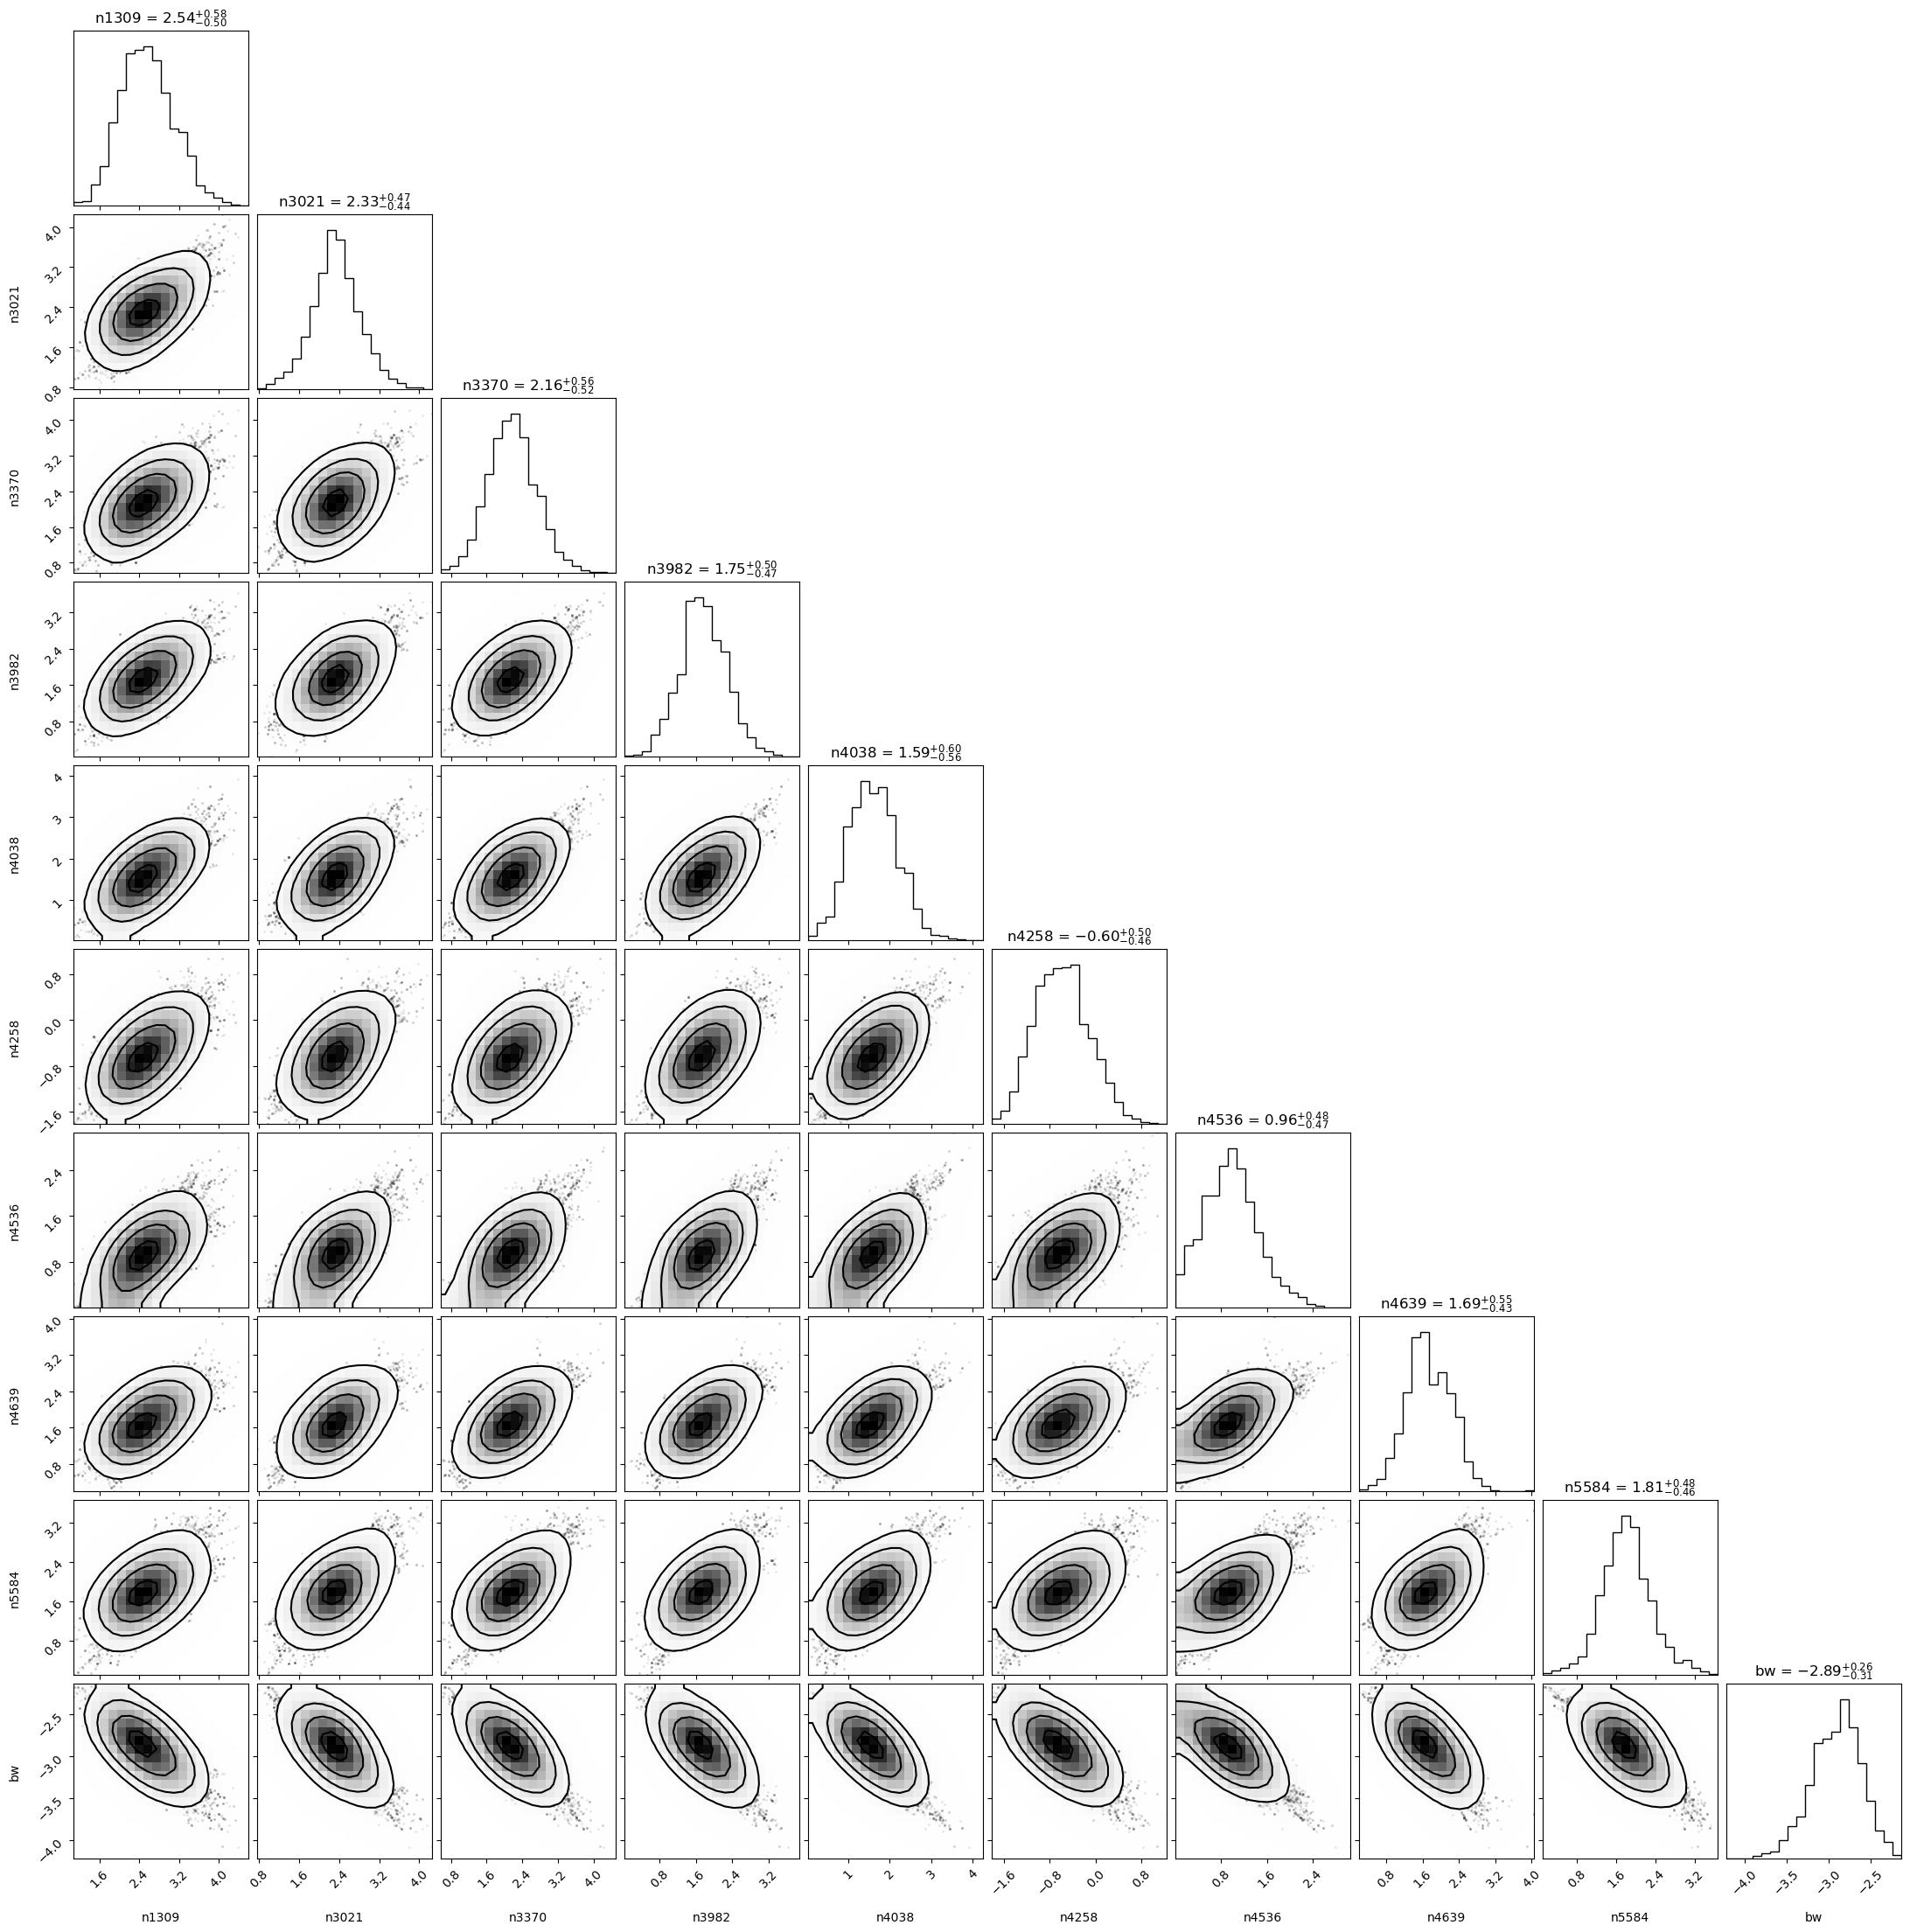

In [14]:
fig2 = corner.corner(samples[::10,:], plot_contours=True, show_titles=True, smooth=2,labels = labels)

### Plots and Intercepts

In [15]:
mcmc_res = np.percentile(samples[::10, :], [50], axis=0).flatten()
intercepts = mcmc_res[:-1] - mcmc_res[5]
intercepts = np.concatenate((intercepts[:5], intercepts[6:]))
print("Intercepts: ", intercepts)

Intercepts:  [3.13166114 2.92638932 2.75753294 2.34182847 2.1847097  1.55117192
 2.28906656 2.40293654]


Reiss et al. values for these intercepts: [3.276, 3.138, 2.835, 2.475, 2.396, 1.567, 2.383, 2.461]

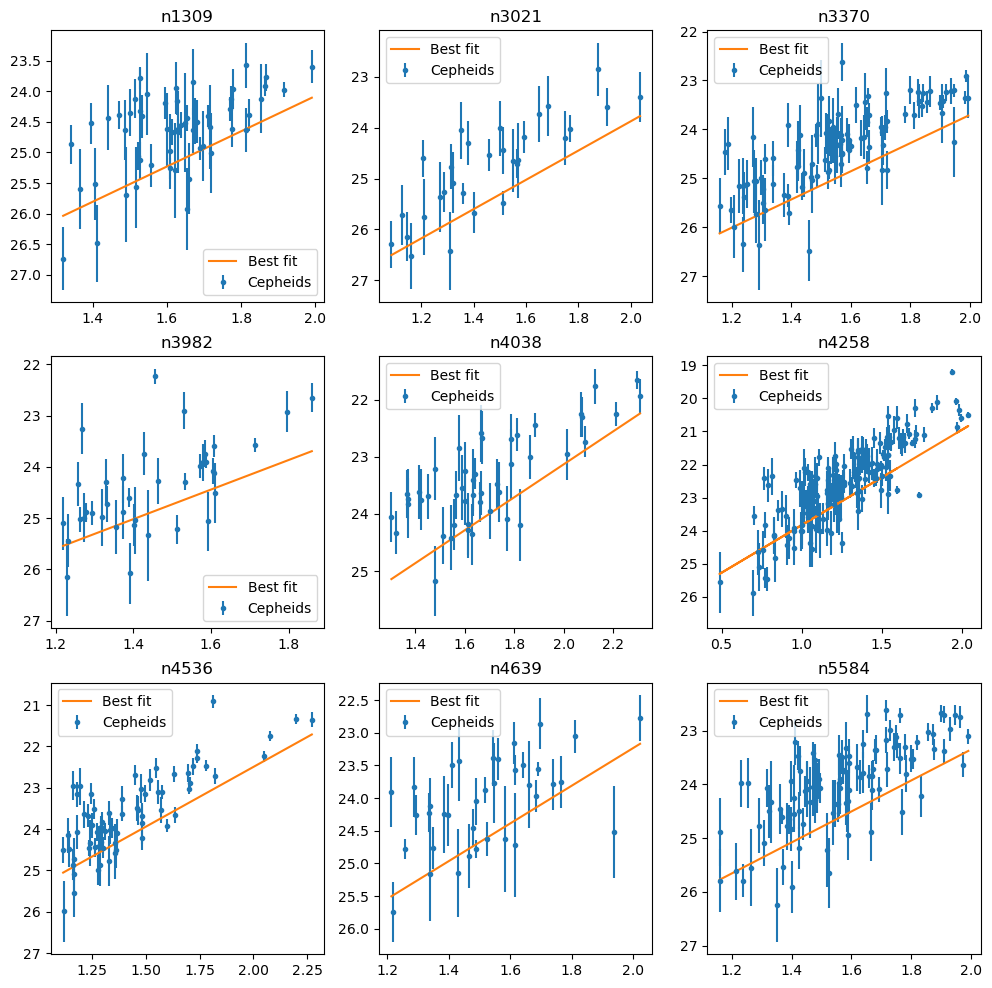

In [16]:
fig3, ax3 = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i in range(3):
    for j in range(3):
        ax3[i, j].errorbar(logPArray[3*i + j], mObsArray[3*i + j], yerr=dmArray[3*i + j], marker=".", ls="none", label="Cepheids")
        intercept = mcmc_res[3*i + j] - mcmc_res[5] + zpval
        slope = mcmc_res[-1]
        ax3[i, j].plot(logPArray[3*i + j], intercept + slope*logPArray[3*i + j], label="Best fit")
        ax3[i, j].invert_yaxis()
        ax3[i, j].set_title(labels[3*i + j])
        ax3[i, j].legend()

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

Equation 3 is:

$$m_{v,i}^0 = (\mu_{0,i} - \mu_{0, 4258}) + m_{v, 4258}^0$$

which we can re-write as:

$$ m_{v, 4258}^0 - \mu_{0, 4258}= m_{v,i}^0 - \mu_{0,i}$$

Equation 4 is:

$$ \log{H_0} = \frac{(m_{v, 4258}^0 - \mu_{0, 4258}) + 5a_v + 25}{5} $$

Substituting equation 3 into equation 4, we get:

$$ \log{H_0} = \frac{(m_{v,i}^0 - \mu_{0,i}) + 5a_v + 25}{5} $$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [21]:
# Taken from Humphrey et al
mu4258 = 5*np.log10(7.6e5)
# Taken from Reiss et al.
mvav = [15.147, 16.040, 16.545, 15.953, 16.699, 16.768, 16.274, 15.901]
H0s = (mvav - (mu4258 + intercepts) + 25)/5
10**H0s

array([ 33.28543068,  55.1961192 ,  75.28003632,  69.40978728,
       105.20695915, 145.39585448,  82.44666537,  65.88690378])

In [18]:
print("The Hubble Constant is:", np.mean(10**H0s))

The Hubble Constant is: 79.01346953162135
